# Imports/Setup

The work shown here identifies if there are any combination of assets in [this portfolio](https://docs.google.com/spreadsheets/d/1EZj5M7dXGy-48i0PydZQa5gpUOYCQHDFRBlp_rU1sdo/edit#gid=332416938) that might benefit from [pairs trading](https://www.investopedia.com/terms/p/pairstrade.asp).

[Helpful article...](https://blog.quantinsti.com/pairs-trading-basics/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import scipy.stats as st
from dateutil.relativedelta import relativedelta
import seaborn as sns

# Collect Returns Data

This section collects return data from all assets in the portfolio from the past year.

In [2]:
investments = pd.read_csv('../Portfolio/investments.csv')
investments['weights'] = investments['initial_investment'] / investments['initial_investment'].sum()
investments.head()

,investment_type,GCIS_sector,name,country_of_origin,ticker,price_per_unit,initial_investment,number_of_units,weights
0,stocks,Energy,Exxon Mobil Corp,U.S.,XOM,116.70,400000,3427.592117,0.0500
1,stocks,Energy,PetroChina Co Ltd,China,PCCYF,0.66,400000,606060.606100,0.0500
2,stocks,Energy,NextEra Energy Inc.,U.S.,NEE,68.64,200000,2913.752914,0.0250
3,stocks,Materials,BHP Group Ltd,Austrailia,BHP,58.45,100000,1710.863986,0.0125
4,stocks,Materials,Air Products & Chemicals Inc,U.S.,APD,302.11,100000,331.005263,0.0125


In [3]:
returns_data = pd.DataFrame(pd.date_range(dt.date(2022, 10, 30), periods=500).tolist())
returns_data.columns = ['Date']

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    tmp = tmp.history(start=dt.date(2022, 10, 30), end=dt.date(2023, 10, 30))['Close'].reset_index()
    tmp['Date'] = pd.to_datetime(tmp['Date'].dt.date)
    tmp[ticker] = tmp['Close'].pct_change(1)
    tmp = tmp[['Date', ticker]]

    returns_data = pd.merge(returns_data, tmp, how='inner', on='Date')
    

dates = returns_data.Date
returns_data = returns_data.drop(columns='Date')

# Determine Correlations Between Assets

The first step in making any pairs trade is to identify two assets that are highly correlated. To identify if such a pair exists, the cell below creates a heatmap of the correlations of the returns for all pairs of assets in the portfolio.

<AxesSubplot:>

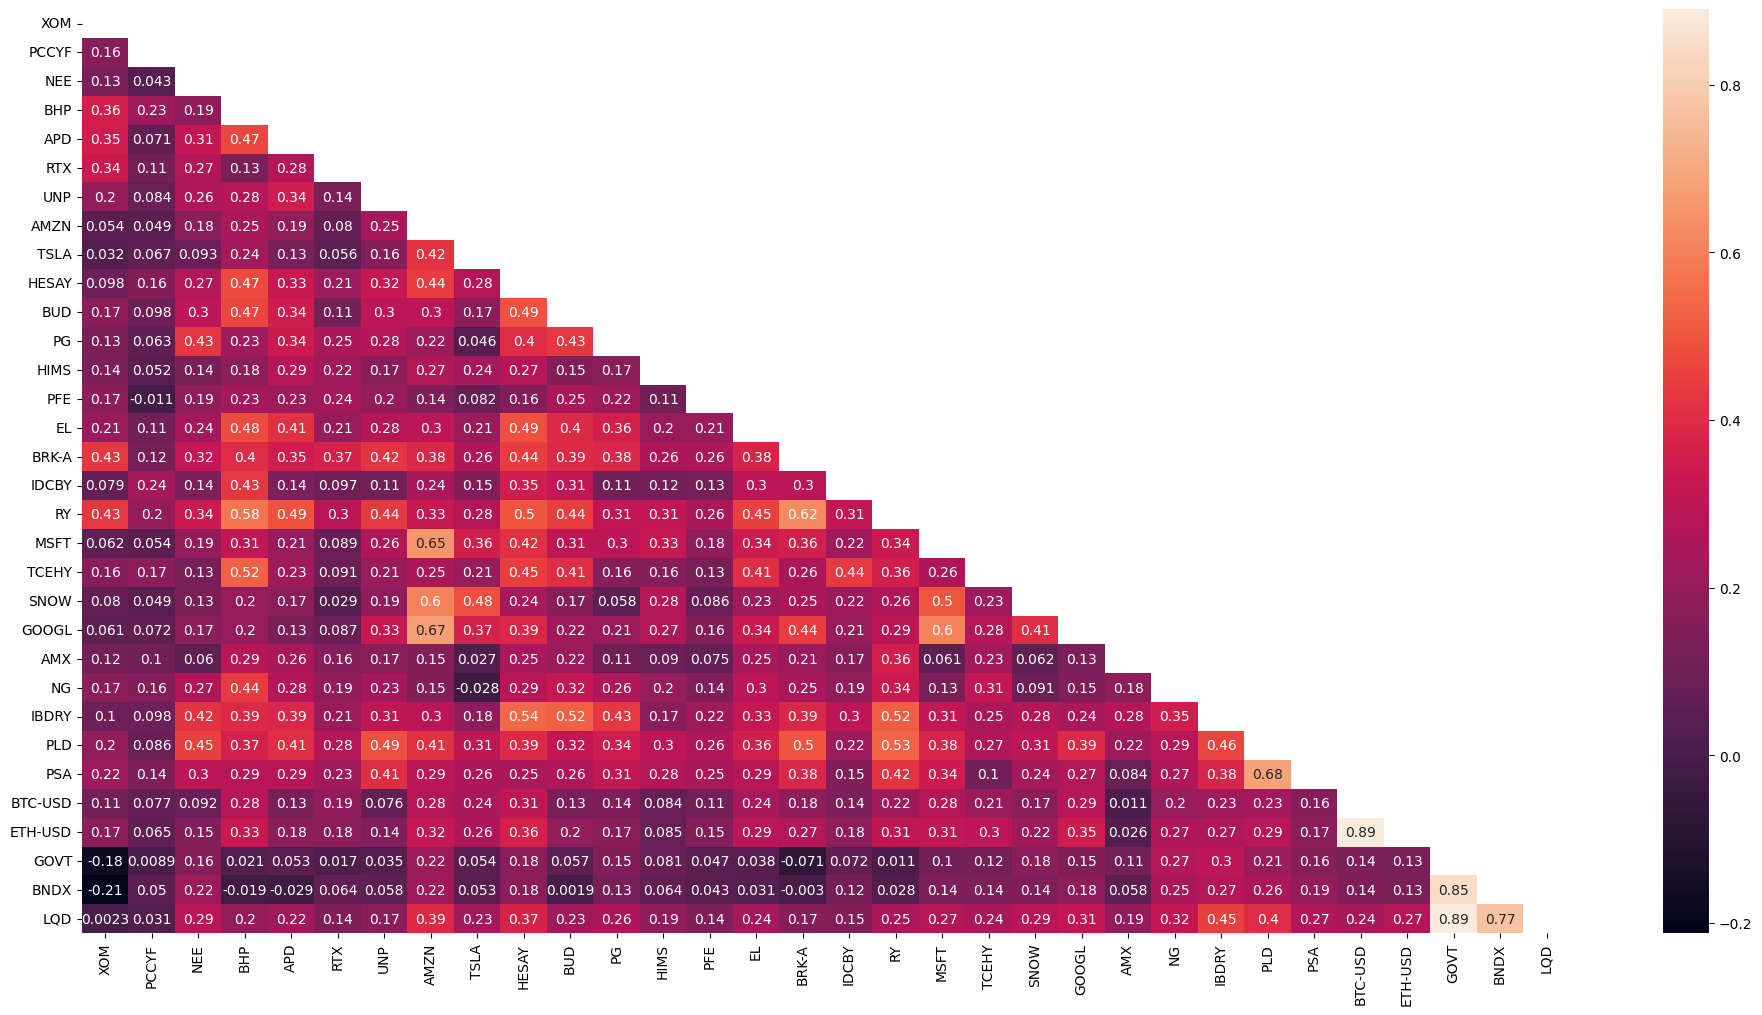

In [4]:
plt.figure(figsize=(24,12))

corr = returns_data.corr()

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)

Based off the above heatmap the highest correlation (and thus the best choice for a pairs trade) are GOVT and LQD. This is unsurprising considering that they are both bond ETFs, and thus their returns over time should exhibit a high degree of correlation. This correlation can be visualized below using the combined candlestick chart:

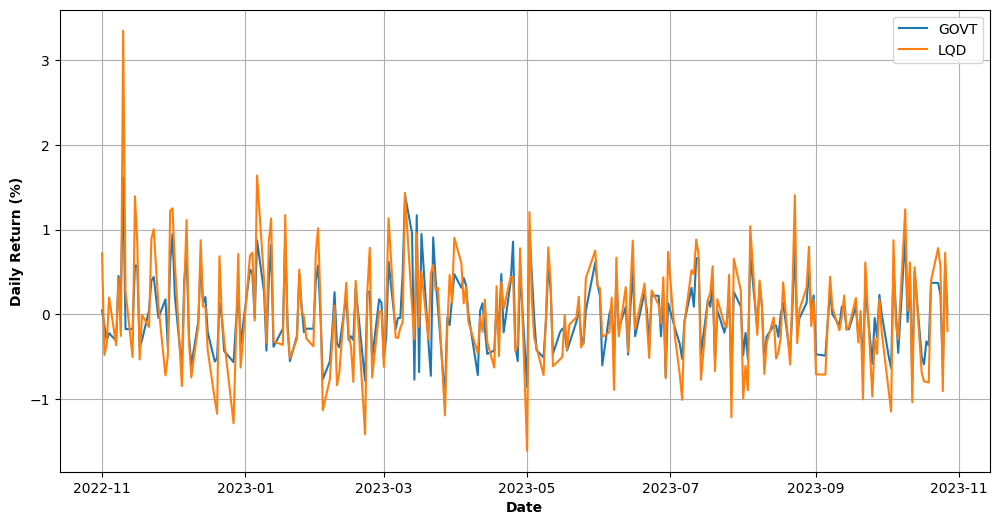

In [5]:
plt.figure(figsize=(12,6))

ff = 0
plt_data = returns_data.iloc[ff:]
plt_dates = dates.iloc[ff:]
plt.plot(plt_dates, plt_data['GOVT'] * 100, label='GOVT')
plt.plot(plt_dates, plt_data['LQD'] * 100, label='LQD')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Daily Return (%)', fontweight='bold')
plt.legend()
plt.grid()

The correlation becomes even clearer when shrinking the timescale of the candlestick plot:

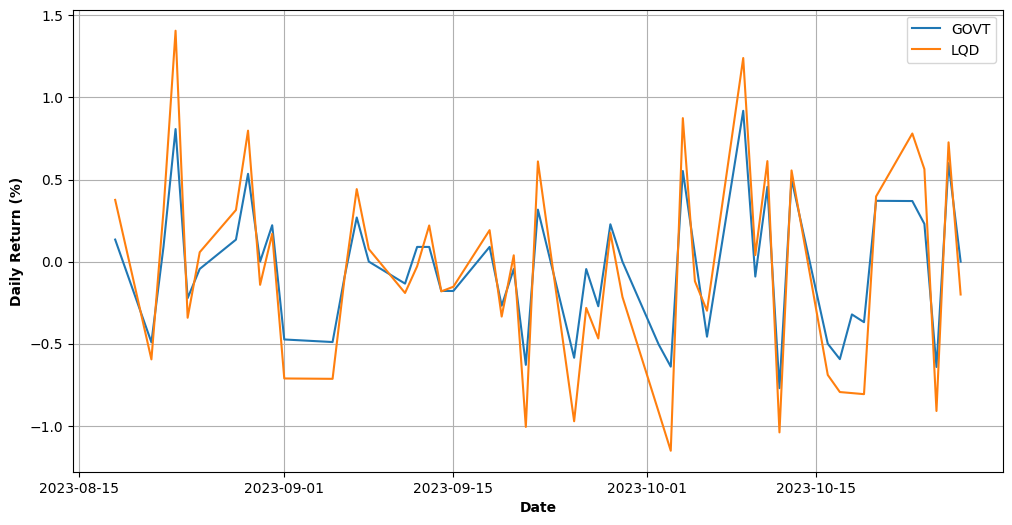

In [6]:
plt.figure(figsize=(12,6))

ff = 200
plt_data = returns_data.iloc[ff:]
plt_dates = dates.iloc[ff:]
plt.plot(plt_dates, plt_data['GOVT'] * 100, label='GOVT')
plt.plot(plt_dates, plt_data['LQD'] * 100, label='LQD')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Daily Return (%)', fontweight='bold')
plt.legend()
plt.grid()

# Examples

The cell below calculates the growth data of both the GOVT and LQD ETFs starting from approximately one year ago (arbitrarily chosen). A plot of these values shows that they intersect on 2022-11-09, making it a reasonable starting point for when we can try and calculate profits from hypothetical pairs trades. 

In [7]:
growth_data = pd.DataFrame(pd.date_range(dt.date(2022, 10, 30), periods=500).tolist())
growth_data.columns = ['Date']

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    tmp = tmp.history(start=dt.date(2022, 10, 30), end=dt.date(2023, 10, 30))['Close'].reset_index()
    tmp['Date'] = pd.to_datetime(tmp['Date'].dt.date)
    tmp[ticker] = (tmp['Close'] - tmp['Close'].iloc[0]) / tmp['Close'].iloc[0] 
    tmp = tmp[['Date', ticker]]

    growth_data = pd.merge(growth_data, tmp, how='inner', on='Date')
    

dates = growth_data.Date
growth_data = growth_data.drop(columns='Date')

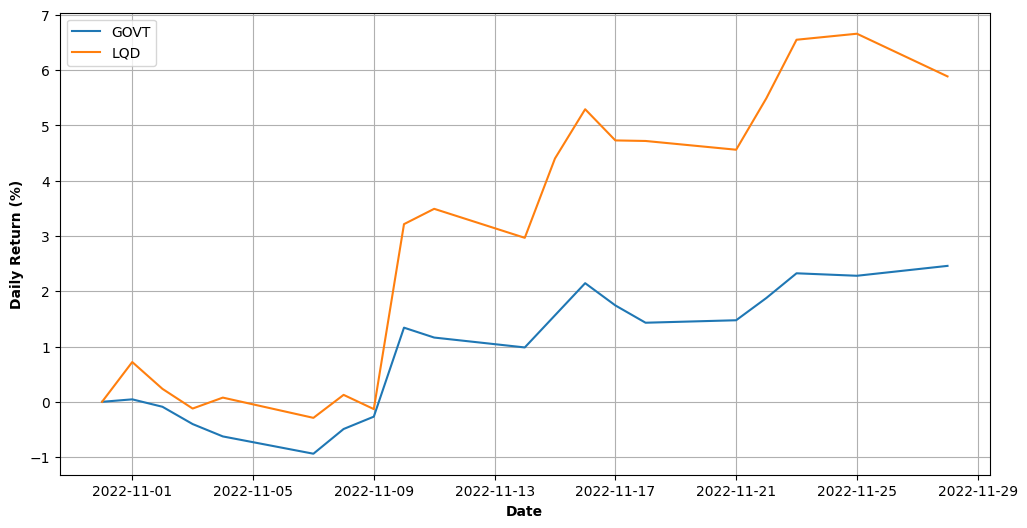

In [8]:
plt.figure(figsize=(12,6))

ff = 0
re = 20
plt_data = growth_data.iloc[ff:re]
plt_dates = dates.iloc[ff:re]
plt.plot(plt_dates, plt_data['GOVT'] * 100, label='GOVT')
plt.plot(plt_dates, plt_data['LQD'] * 100, label='LQD')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Daily Return (%)', fontweight='bold')
plt.legend()
plt.grid()

To determine when we should enter and exit into pairs trades, we need to have an indicator telling us when to do so. One of the most common and well suited indicators to use is the standard deviation of the spread between between the two stock prices, where spread is defined as:

$$
\begin{equation}
S = \log{p_1} - n\log{p_2}
\end{equation}
$$

Here, $p_1$ equals the price of the first stock (GOVT), $p_2$ is the price of the second stock (LQD), and $n$ is the price ratio. $n$ is a constant and is the value that will make $S=0$ at the beginning of our time series (2023-11-09). Thus, to calculate $n$ and $S$, the cell below brings in price data for each of the two stocks:

In [9]:
close_data = pd.DataFrame(pd.date_range(dt.date(2022, 10, 30), periods=500).tolist())
close_data.columns = ['Date']

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    tmp = tmp.history(start=dt.date(2022, 10, 30), end=dt.date(2023, 10, 30))['Close'].reset_index()
    tmp['Date'] = pd.to_datetime(tmp['Date'].dt.date)
    tmp.columns = ['Date', ticker]

    close_data = pd.merge(close_data, tmp, how='inner', on='Date')
    

dates = close_data.Date
df = close_data[['Date', 'GOVT', 'LQD']]

Next, the cell below calculates the rolling mean, standard deviation, and $z$-score of the spread between the two assets.

In [10]:
df.columns = ['Date', 'A1', 'A2']
df = df[df['Date'] >= dt.datetime(2022, 11, 9)].reset_index()
n = np.log(df['A1'].iloc[0]) / np.log(df['A2'].iloc[0])

df['S'] = np.log(df['A1']) - n * np.log(df['A2'])
df['S_mean'] = df['S'].expanding().mean()
df['S_std'] = df['S'].expanding().std()
df['z'] = (df['S'] - df['S_mean']) / df['S_std']

A common threshold used as an indicator for a pairs trade is when $z > 1.5$ or $z < 1.5$. In this case:

* when $z > 1.5$ then buy $p_2$ (LQD) and short $p_1$ (GOVT).
* when $z < -1.5$ then buy $p_1$ (GOVT) and short $p_1$ (LQD).

For this example, when either condition is met, we will take a hypothetical $100 short and long position for the instructed asset. The cell below prints out all the times in which these conditions are met, and the profit made once each position is closed out: 

In [11]:
money_spent = 0
money_made = 0
A1_shares_bought = 0
A1_shares_borrowed = 0 
A2_shares_bought = 0
A2_shares_borrowed = 0
z_threshold = 1.5


for index, row in df.iterrows():
    date = row['Date']
    z = row['z']
    A2 = row['A2']
    A1 = row['A1']
    
    if z > z_threshold and df.iloc[index-1]['z'] <= z_threshold:
        print(f'Indicator broken at {date}: z = {z}')
        print(f'Short A1, Buy A2...')
        A2_shares_bought = 100 / A2
        A1_shares_borrowed = 100 / A1
        money_spent += 100
        money_made += 100
        
    if z <= z_threshold and df.iloc[index-1]['z'] > z_threshold:
        print(f'Indicator broken at {date}: z = {z}')
        print(f'Closing position...')
        money_spent += A1_shares_borrowed * A1
        money_made += A2_shares_bought * A2
        A2_shares_bought = 0 
        A1_shares_borrowed = 0
        print('\n\n')
        
    if z < -z_threshold and df.iloc[index-1]['z'] >= -z_threshold:
        print(f'Indicator broken at {date}: z = {z}')
        print(f'Buy $100 worth of A1 at {A1:.2f}, Short $100 woth of A2 at {A2:.2f}...')
        A1_shares_bought = 100 / A1
        A2_shares_borrowed = 100 / A2
        money_spent += 100
        money_made += 100
        
    if z >= -z_threshold and df.iloc[index-1]['z'] < -z_threshold:
        print(f'Indicator broken at {date}: z = {z}')
        print(f'Sell {A1_shares_bought:.2f} shares of GOVT at {A1:.2f}, return {A2_shares_borrowed} shares of A2 at {A2:.2f}...')
        money_spent += A2_shares_borrowed * A2
        money_made += A1_shares_bought * A1
        long_position_profit = (A1_shares_bought * A1) - 100
        short_position_profit = 100 - (A2_shares_borrowed * A2)
        total_profit = long_position_profit + short_position_profit
        print(f'Long Position Profit: {long_position_profit}')
        print(f'Short Position Profit: {short_position_profit}')
        print(f'Total Profit: {total_profit}')
        print(f'Closing position...')
        A1_shares_bought = 0
        A2_shares_borrowed = 0

        print('\n\n')
    

Indicator broken at 2023-01-13 00:00:00: z = -1.5283458026526187
Buy $100 worth of A1 at 22.85, Short $100 woth of A2 at 107.15...
Indicator broken at 2023-01-17 00:00:00: z = -1.2772787802616479
Sell 4.38 shares of GOVT at 22.81, return 0.9332383424595677 shares of A2 at 106.77...
Long Position Profit: -0.17174703289114746
Short Position Profit: 0.3620898125136023
Total Profit: 0.19034277962245483
Closing position...



Indicator broken at 2023-01-23 00:00:00: z = -1.5507763507163197
Buy $100 worth of A1 at 22.80, Short $100 woth of A2 at 106.92...
Indicator broken at 2023-01-24 00:00:00: z = -1.1831195166201625
Sell 4.39 shares of GOVT at 22.91, return 0.9352702534438819 shares of A2 at 107.48...
Long Position Profit: 0.4733226040406606
Short Position Profit: -0.5261751441112636
Total Profit: -0.05285254007060303
Closing position...



Indicator broken at 2023-02-01 00:00:00: z = -1.598914062391581
Buy $100 worth of A1 at 23.02, Short $100 woth of A2 at 108.63...
Indicator broken at 

Overall, the strategy did not seem to make much money: 

In [12]:
print(f'Money made: ${money_made:,.2f}')
print(f'Money spent: ${money_spent:,.2f}')

Money made: $2,396.44
Money spent: $2,393.51


This might be due to the strategy being used to determine when to exit the trade. In the above, the trade ends simply when the $z$ score goes back within the range $-1.5 < z < 1.5$. However, a better strategy might be instead to end the trade once the rolling average has reverted back to 0. This is done in the cells below using GOOGL and AMZN as an example:

In [13]:
df = close_data[['Date', 'GOOGL', 'AMZN']]

df.columns = ['Date', 'A1', 'A2']
df = df[df['Date'] >= dt.datetime(2022, 11, 9)].reset_index()
n = np.log(df['A1'].iloc[0]) / np.log(df['A2'].iloc[0])

df['S'] = np.log(df['A1']) - n * np.log(df['A2'])
df['S_mean'] = df['S'].expanding().mean()
df['S_std'] = df['S'].expanding().std()
df['z'] = (df['S'] - df['S_mean']) / df['S_std']

breaks = []

for index, row in df.iterrows():
    date = row['Date']
    z = row['z']
    A2 = row['A2']
    A1 = row['A1']
    mean = row['S_mean']
    
    if z > z_threshold and df.iloc[index-1]['z'] <= z_threshold:
        print(f'Indicator broken at {date}: z = {z}')
        tmp = df.iloc[index:]
        if mean > 0:
            tmp = tmp[tmp['S_mean'] < 0]
            if tmp.shape[0] > 0:
                tmp = tmp.iloc[0]
                breaks.append([date, tmp['Date'], A1, A2, 'shortlong', tmp['A1'], tmp['A2']])
            else:
                breaks.append([date, None, A1, A2, 'shortlong', None, None])
        else:
            tmp = tmp[tmp['S_mean'] > 0]
            if tmp.shape[0] > 0:
                tmp = tmp.iloc[0]
                breaks.append([date, tmp['Date'], A1, A2, 'shortlong', tmp['A1'], tmp['A2']])
            else:
                breaks.append([date, None, A1, A2, 'shortlong', None, None])
            
    if z < -z_threshold and df.iloc[index-1]['z'] >= -z_threshold:
        print(f'Indicator broken at {date}: z = {z}')
        tmp = df.iloc[index:]
        if mean > 0:
            tmp = tmp[tmp['S_mean'] < 0] 
            if tmp.shape[0] > 0:
                tmp = tmp.iloc[0]
                breaks.append([date, tmp['Date'], A1, A2, 'longshort', tmp['A1'], tmp['A2']])
            else:
                breaks.append([date, None, A1, A2, 'longshort', None, None])
        else:
            tmp = tmp[tmp['S_mean'] > 0]
            if tmp.shape[0] > 0:
                tmp = tmp.iloc[0]
                breaks.append([date, tmp['Date'], A1, A2, 'shortlong', tmp['A1'], tmp['A2']])
            else:
                breaks.append([date, None, A1, A2, 'shortlong', None, None])
        
breaks = pd.DataFrame(breaks, columns=['start_date', 'end_date', 'A1i', 'A2i', 'type', 'A1f', 'A2f'])
breaks

Indicator broken at 2022-12-05 00:00:00: z = 1.8481037874610367
Indicator broken at 2023-01-10 00:00:00: z = -1.773944445807414
Indicator broken at 2023-01-30 00:00:00: z = -1.5428584800360012
Indicator broken at 2023-02-13 00:00:00: z = -1.678609743233433
Indicator broken at 2023-02-23 00:00:00: z = -1.5328140863878499
Indicator broken at 2023-03-23 00:00:00: z = 1.5798529387110751
Indicator broken at 2023-04-12 00:00:00: z = 1.503683936203685
Indicator broken at 2023-05-22 00:00:00: z = 1.9335663960493317
Indicator broken at 2023-05-25 00:00:00: z = 1.5496057671582832
Indicator broken at 2023-06-22 00:00:00: z = -1.910795657978518
Indicator broken at 2023-08-04 00:00:00: z = -1.9606168870360874
Indicator broken at 2023-10-04 00:00:00: z = 1.5048257358011063
Indicator broken at 2023-10-18 00:00:00: z = 1.6504217006089654


,start_date,end_date,A1i,A2i,type,A1f,A2f
0,2022-12-05,2023-02-13,99.480003,91.010002,shortlong,94.610001,99.540001
1,2023-01-10,2023-02-13,88.419998,89.870003,longshort,94.610001,99.540001
2,2023-01-30,2023-02-13,96.940002,100.550003,longshort,94.610001,99.540001
3,2023-02-13,2023-05-24,94.610001,99.540001,shortlong,120.900002,116.750000
4,2023-02-23,2023-05-24,90.889999,95.820000,shortlong,120.900002,116.750000
5,2023-03-23,2023-05-24,105.599998,98.709999,shortlong,120.900002,116.750000
6,2023-04-12,2023-05-24,104.639999,97.830002,shortlong,120.900002,116.750000
7,2023-05-22,2023-05-24,125.050003,115.010002,shortlong,120.900002,116.750000
8,2023-05-25,2023-06-12,123.480003,115.000000,shortlong,123.639999,126.570000
9,2023-06-22,NaT,123.150002,130.149994,shortlong,NaN,NaN


The output above shows all the trades suggested by this new algorithm and when they should be opened and closed. The cell below defines a function that can be used to determine the profit made from each trade.

In [14]:
def calc_profit(p1i, p1f, p2i, p2f, trade_type, trade_amount):
    money_spent = 0
    money_made = 0
    p2_buy = 0
    p1_borrow = 0
    p2_borrow = 0 
    p1_buy = 0
    
    if trade_type == 'shortlong':
        money_spent += trade_amount
        money_made += trade_amount
        p2_buy = trade_amount / p2i
        p1_borrow = trade_amount / p1i
        
        money_spent += p1_borrow * p1f
        money_made += p2_buy * p2f
        return((money_spent, money_made))
    
    elif trade_type == 'longshort':
        money_spent += trade_amount
        money_made += trade_amount
        p1_buy = trade_amount / p1i
        p2_borrow = trade_amount / p2i
        
        money_spent += p2_borrow * p2f
        money_made += p1_buy * p1f
        return((money_spent, money_made))
    else:
        return 'invalid trade type'

This function is implemented in the cell below and simulates acting on the positions suggested by the algorithm using $100 trades: 

In [15]:
money_spent = 0
money_made = 0 
valid_trades = breaks.dropna()

for index, row in valid_trades.iterrows():
    ms, mm = calc_profit(row['A1i'], row['A1f'], row['A2i'], row['A2f'], row['type'], 100)
    money_spent += ms
    money_made += mm

Once again, we see that this process did not generate a considerable amount of profit: 

In [16]:
print(f'Money made: ${money_made:,.2f}')
print(f'Money spent: ${money_spent:,.2f}')

Money made: $1,902.29
Money spent: $1,892.50


# Conclusion

There are a number of factors that could be limiting the ability of the pairs-trading methodology to generate worthwhile profits:

* selection of paired assets (it is hard to determine when assets are actually correlated)
* derivation of the hedge ratio, $n$
* fine tuning of the indicators used to enter and exit trades

It might be best to first re-test this process using two well known paired stocks (i.e. VOO and QQQ) in order to make sure the algorithm is capable of recommending profitable trades. Once this is complete, we can return to assessing the assets included in the portfolio.

